<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [95]:
from collections import Counter
import glob
from IPython.display import display
from datetime import datetime

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ'''
    with open(site_freq_path, 'rb') as fin:
        site_dict = pickle.load(fin)
    
    window_size = session_length
    
    site_chains = []
    for e in tqdm_notebook(glob.glob(os.path.join(path_to_csv_files, '*.csv'))):
        user_id = int(e.split('\\')[-1].split('user')[1][:-4])
        df = pd.read_csv(e)
        df['siteId'] = df['site'].apply(lambda x: site_dict[x][0])
        sites = list(zip(df['siteId'], df['timestamp']))
        site_chain = []
        n_chains = 0
        #display(df)
        for i, (siteId, siteTimestamp) in enumerate(sites + [(-1, 0)] * (session_length - 1)):
            if siteId != -1:
                site_chain.append((siteId, datetime.strptime(siteTimestamp, '%Y-%m-%d %H:%M:%S')))
            if (i + 1 - session_length) >= 0 and (i + 1 - session_length) % window_size == 0:
                cur_site_chain = site_chain[(i + 1 - session_length):]
                if len(cur_site_chain) != session_length:
                    cur_site_chain += [(0, 0)] * (session_length - len(cur_site_chain))
                #print(i, cur_site_chain)
                diffs = []
                for j in range(1, len(cur_site_chain)):
                    dtime = 0
                    if cur_site_chain[j][1] != 0:
                        dtime = (cur_site_chain[j][1] - cur_site_chain[j - 1][1]).seconds
                    diffs.append(dtime)
                try:
                    minTime = min([e[1] for e in cur_site_chain if e[1] != 0])
                except:
                    print(site_chain)
                    print(cur_site_chain)
                maxTime = max([e[1] for e in cur_site_chain if e[1] != 0])
                start_hour = minTime.hour
                day_of_week = minTime.weekday()
                session_timespan = (maxTime - minTime).seconds
                siteIds = [e[0] for e in cur_site_chain] 
                site_chains.append(siteIds + diffs + 
                                   [session_timespan, len(set(siteIds) - {0}), start_hour, day_of_week] + [user_id])
                n_chains += 1
        print(e, user_id, n_chains)
    data = pd.DataFrame(site_chains, columns = feature_names)
    return data

**Проверим функцию на игрушечном примере.**

In [96]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

capstone_user_identification\3users\user0001.csv 1 2
capstone_user_identification\3users\user0002.csv 2 1
capstone_user_identification\3users\user0003.csv 3 2



In [97]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [98]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [99]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10) 

capstone_user_identification\10users\user0031.csv 31 760
capstone_user_identification\10users\user0033.csv 33 1022
capstone_user_identification\10users\user0039.csv 39 2204
capstone_user_identification\10users\user0050.csv 50 802
capstone_user_identification\10users\user0100.csv 100 720
capstone_user_identification\10users\user0127.csv 127 1712
capstone_user_identification\10users\user0128.csv 128 2796
capstone_user_identification\10users\user0207.csv 207 1868
capstone_user_identification\10users\user0237.csv 237 1643
capstone_user_identification\10users\user0241.csv 241 534

Wall time: 2.21 s


In [100]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [101]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

capstone_user_identification\150users\user0006.csv 6 2137
capstone_user_identification\150users\user0013.csv 13 589
capstone_user_identification\150users\user0015.csv 15 767
capstone_user_identification\150users\user0016.csv 16 2094
capstone_user_identification\150users\user0028.csv 28 1651
capstone_user_identification\150users\user0031.csv 31 760
capstone_user_identification\150users\user0033.csv 33 1022
capstone_user_identification\150users\user0039.csv 39 2204
capstone_user_identification\150users\user0046.csv 46 394
capstone_user_identification\150users\user0049.csv 49 845
capstone_user_identification\150users\user0050.csv 50 802
capstone_user_identification\150users\user0053.csv 53 1090
capstone_user_identification\150users\user0065.csv 65 422
capstone_user_identification\150users\user0066.csv 66 704
capstone_user_identification\150users\user0082.csv 82 500
capstone_user_identification\150users\user0085.csv 85 521
capstone_user_identification\150users\user0089.csv 89 1360
capstone

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [102]:
''' ВАШ КОД ЗДЕСЬ '''
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [103]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [104]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [107]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users.day_of_week.median(), datetime.now().weekday()

(2.0, 1)

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [108]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [110]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [111]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [112]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [140]:
train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,John
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,John
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,John
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,John
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,John
5,31,30,27,27,14,14,32,33,34,35,0,0,1,63,1,1,844,184,4,1098,8,8,4,John
6,36,2,3,4,3,10,3,11,1,3,1499,0,0,1,2,0,11,1,0,1514,7,8,4,John
7,37,38,39,11,14,4,14,4,22,23,2,5,9,10,0,1,0,1,0,28,8,9,1,John
8,14,17,40,5,41,42,14,43,40,15,1,0,0,1,0,0,0,0,0,2,8,9,1,John
9,44,36,45,36,46,47,48,48,47,49,3,0,1,0,1,1,1,2,0,9,7,9,1,John


**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

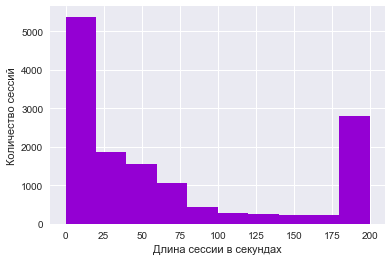

In [120]:
''' ВАШ КОД ЗДЕСЬ '''
plt.hist(np.minimum(train_data_10users['session_timespan'], 200), color='darkviolet');
plt.xlabel('Длина сессии в секундах')
plt.ylabel('Количество сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

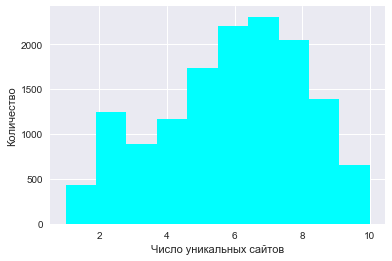

In [121]:
plt.hist(train_data_10users['#unique_sites'], color='aqua');
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Количество')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

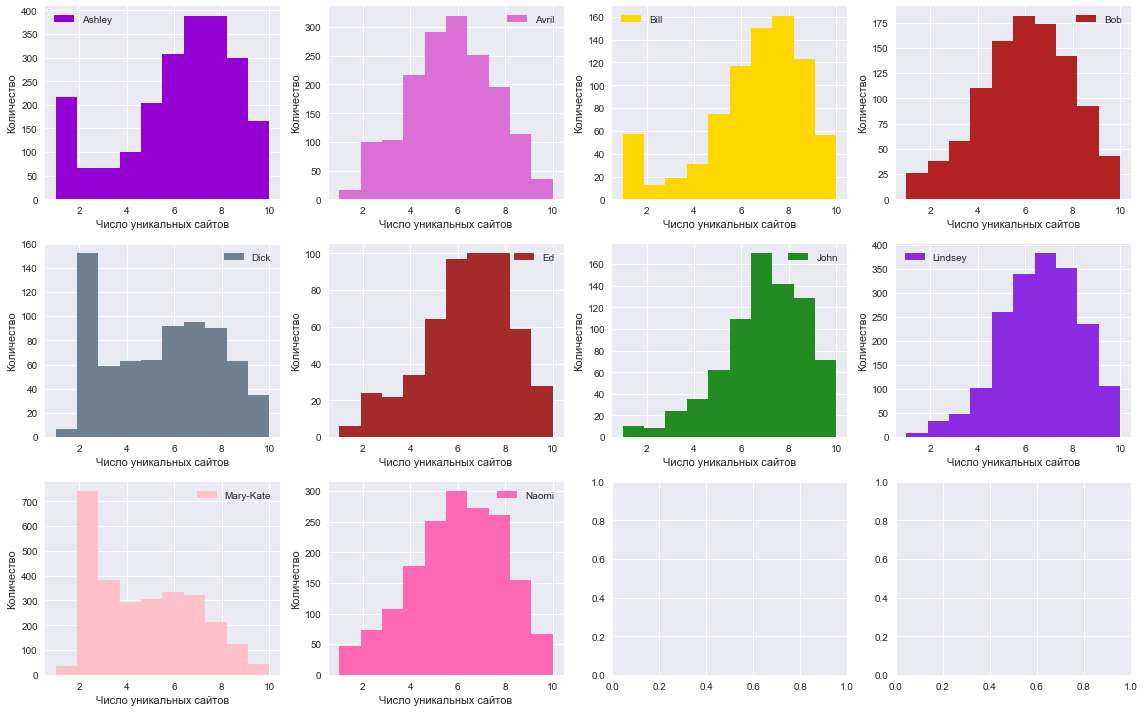

In [145]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    plt.subplot(3, 4, idx + 1)
    plt.hist(sub_df['#unique_sites'], color=color_dic[user], label=user)
    plt.legend()
    plt.xlabel('Число уникальных сайтов')
    plt.ylabel('Количество')
    plt.tight_layout()


**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

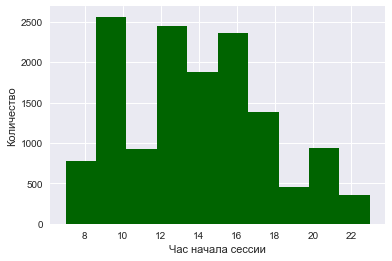

In [151]:
 ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

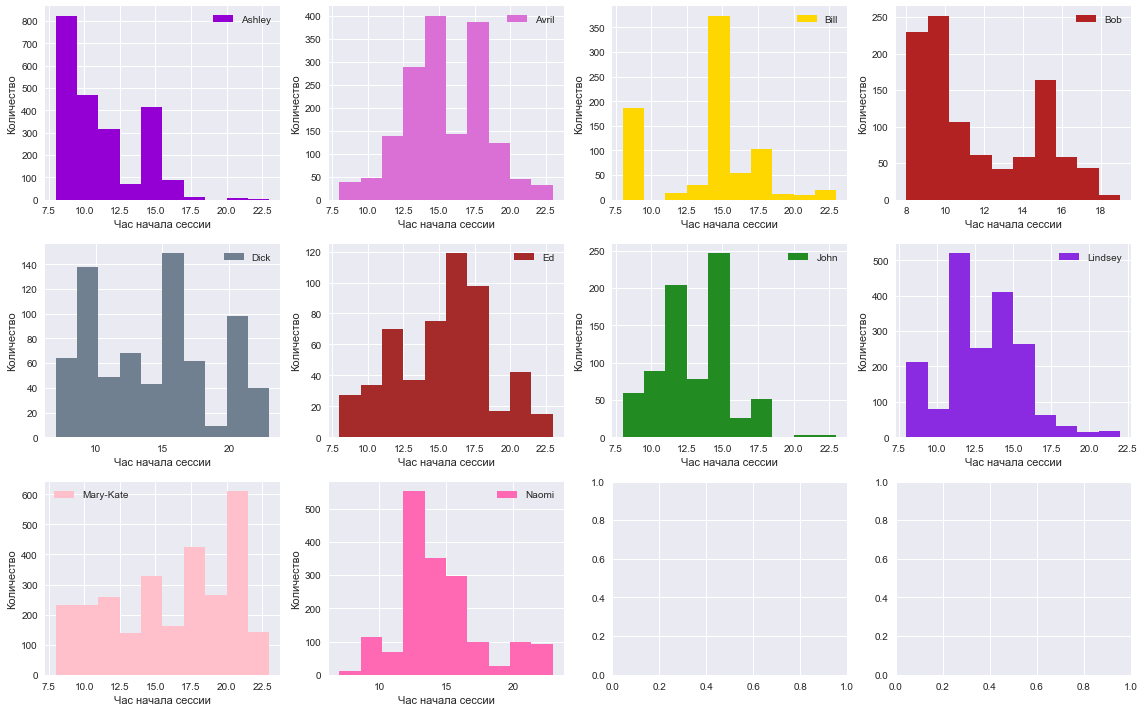

In [153]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    plt.subplot(3, 4, idx + 1)
    plt.hist(sub_df['start_hour'], color=color_dic[user], label=user)
    plt.legend()
    plt.xlabel('Час начала сессии')
    plt.ylabel('Количество')
    plt.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

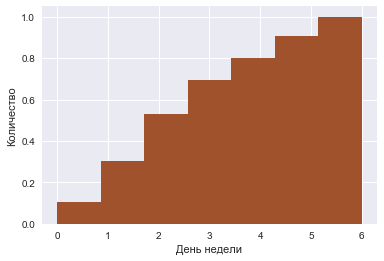

In [161]:
train_data_10users['day_of_week'].hist(bins=7, color='sienna', cumulative=True, normed=True)
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

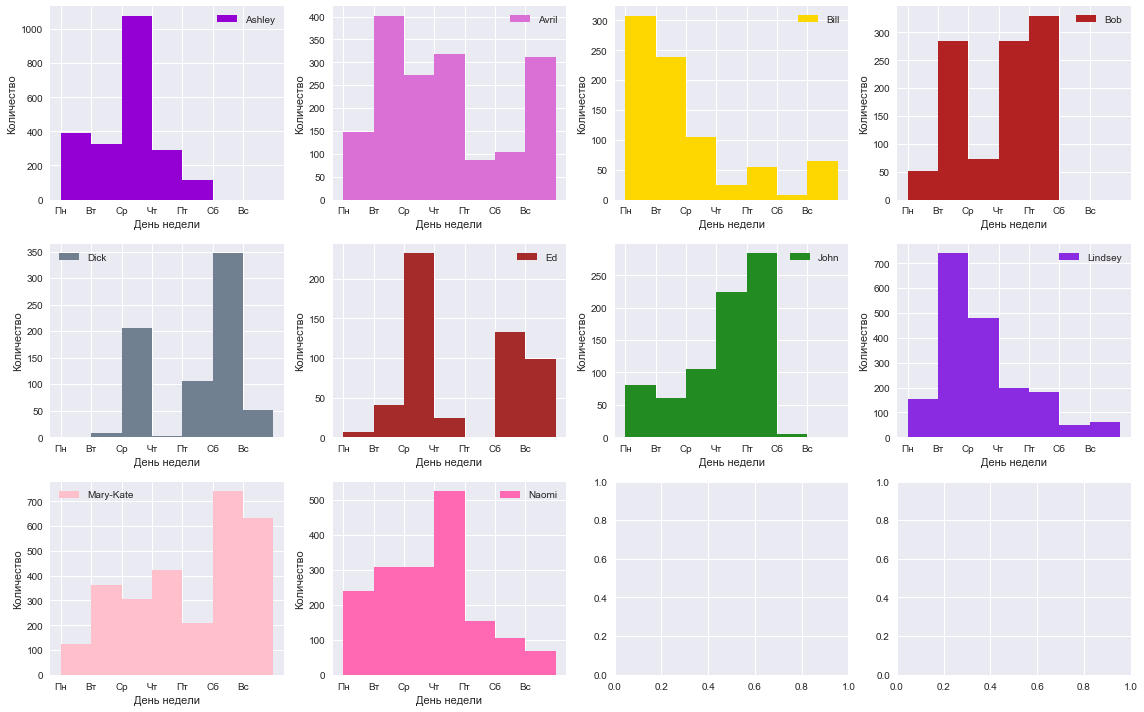

In [202]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = plt.subplot(3, 4, idx + 1)
    plt.hist(sub_df['day_of_week'], bins=np.arange(8), color=color_dic[user], label=user)
    plt.legend()
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    plt.xlabel('День недели')
    plt.ylabel('Количество')
    plt.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [203]:
''' ВАШ КОД ЗДЕСЬ '''
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as fin:
    site_dict = pickle.load(fin)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [204]:
site_dict

{'catalogue.clermont-universite.fr': (3831, 18),
 'www-sop.inria.fr': (2257, 5),
 'video.lefigaro.fr': (3378, 1),
 'www.techonthenet.com': (2419, 8),
 'r15.imgfast.net': (461, 2),
 'www.get-the-look.fr': (2962, 1),
 'www.webutation.net': (1633, 1),
 'aruba-it.bench.cedexis.com': (478, 3),
 'netbeans.developpez.com': (1560, 2),
 'math.agrocampus-ouest.fr': (180, 11),
 'help.talend.com': (2787, 6),
 'archive.eclipse.org': (2657, 1),
 'a69.g.akamai.net': (1639, 5),
 'leadgenservice.monster.com': (3277, 3),
 'lesfutfuts.over-blog.com': (3652, 2),
 'i1-js-14-3-01-11074-845452184-i.init.cedexis-radar.net': (159, 1),
 'images.gx101.com': (1540, 28),
 'echangeetpartage.over-blog.fr': (4588, 2),
 'i1-js-14-3-01-11074-695866183-i.init.cedexis-radar.net': (832, 1),
 'media.apce.com': (4014, 15),
 'kxlogo.knet.cn': (1843, 1),
 'www.telechargement-de-ouf.fr': (2305, 4),
 'dtm.potterybarn.com': (198, 1),
 'r4---sn-gxo5uxg-jqbe.googlevideo.com': (208, 1702),
 'www.crystalmaker.com': (1092, 2),
 'fr.w

In [270]:
''' ВАШ КОД ЗДЕСЬ '''
top10 = sorted(site_dict.items(), key=lambda x: -x[1][1])[:11]
print(top10)
top10_freqs = [e[1][1] for e in top10]
print(top10_freqs)
top10_sites = [e[0] for e in top10]
print(top10_sites)
#top10_sites = [e[1] for e in top10]

[('s.youtube.com', (210, 8300)), ('www.google.fr', (51, 7813)), ('www.google.com', (4, 5441)), ('mail.google.com', (183, 4158)), ('www.facebook.com', (15, 4141)), ('apis.google.com', (52, 3758)), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 3244)), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (214, 3094)), ('plus.google.com', (187, 2630)), ('accounts.google.com', (184, 2089)), ('r2---sn-gxo5uxg-jqbe.googlevideo.com', (699, 1939))]
[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089, 1939]
['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com', 'r2---sn-gxo5uxg-jqbe.googlevideo.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

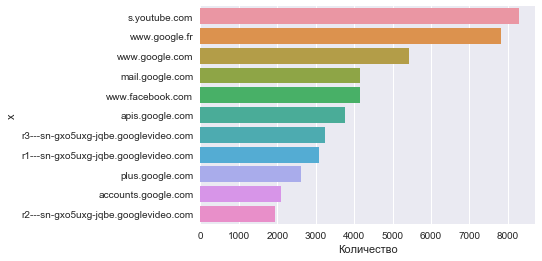

In [289]:
''' ВАШ КОД ЗДЕСЬ '''
df = pd.DataFrame({'x':top10_sites, 'y':top10_freqs})
sns.barplot(data=df, x='y', y='x')
#plt.xticks([-1, 0, 1,  2,  3,  4,  4, 5, 7, 8, 8], top10_sites)
plt.xlabel('Количество')
#plt.xticks(rotation=50)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

На следующей неделе мы наконец приступим к обучению моделей классификации. 